In [9]:
import pandas as pd
df = pd.read_csv('../data/trondheim/ev_charging_reports.csv', sep=';', encoding='utf-8', parse_dates=['Start_plugin','End_plugout'],decimal=',', dayfirst=True)
print(df.head())

   session_ID Garage_ID User_ID User_type Shared_ID        Start_plugin  \
0           1      AdO3  AdO3-4   Private       NaN 2018-12-21 10:20:00   
1           2      AdO3  AdO3-4   Private       NaN 2018-12-21 10:24:00   
2           3      AdO3  AdO3-4   Private       NaN 2018-12-21 11:33:00   
3           4      AdO3  AdO3-2   Private       NaN 2018-12-22 16:15:00   
4           5      AdO3  AdO3-2   Private       NaN 2018-12-24 22:03:00   

   Start_plugin_hour         End_plugout  End_plugout_hour  El_kWh  \
0                 10 2018-12-21 10:23:00              10.0    0.30   
1                 10 2018-12-21 10:32:00              10.0    0.87   
2                 11 2018-12-21 19:46:00              19.0   29.87   
3                 16 2018-12-23 16:40:00              16.0   15.56   
4                 22 2018-12-24 23:02:00              23.0    3.62   

   Duration_hours month_plugin weekdays_plugin             Plugin_category  \
0        0.050000          Dec          Friday    

In [10]:
#standardizing column names
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.columns

Index(['session_id', 'garage_id', 'user_id', 'user_type', 'shared_id',
       'start_plugin', 'start_plugin_hour', 'end_plugout', 'end_plugout_hour',
       'el_kwh', 'duration_hours', 'month_plugin', 'weekdays_plugin',
       'plugin_category', 'duration_category'],
      dtype='object')

In [11]:
#converting el_kwh and duration_hours to numeric, coercing errors to NaN
df['el_kwh'] = pd.to_numeric(df['el_kwh'], errors='coerce')
df['duration_hours'] = pd.to_numeric(df['duration_hours'], errors='coerce')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6878 entries, 0 to 6877
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   session_id         6878 non-null   int64         
 1   garage_id          6878 non-null   object        
 2   user_id            6878 non-null   object        
 3   user_type          6878 non-null   object        
 4   shared_id          1412 non-null   object        
 5   start_plugin       6878 non-null   datetime64[ns]
 6   start_plugin_hour  6878 non-null   int64         
 7   end_plugout        6844 non-null   datetime64[ns]
 8   end_plugout_hour   6844 non-null   float64       
 9   el_kwh             6878 non-null   float64       
 10  duration_hours     6844 non-null   float64       
 11  month_plugin       6878 non-null   object        
 12  weekdays_plugin    6878 non-null   object        
 13  plugin_category    6878 non-null   object        
 14  duration

In [ ]:
df.isna().sum()

session_id              0
garage_id               0
user_id                 0
user_type               0
shared_id            5466
start_plugin            0
start_plugin_hour       0
end_plugout            34
end_plugout_hour       34
el_kwh                  0
duration_hours         34
month_plugin            0
weekdays_plugin         0
plugin_category         0
duration_category      34
dtype: int64

In [ ]:
#dropping rows with missing end_plugout or duration_hours
df = df.dropna(subset=['end_plugout', 'duration_hours'])
df.isna().sum()

session_id              0
garage_id               0
user_id                 0
user_type               0
shared_id            5442
start_plugin            0
start_plugin_hour       0
end_plugout             0
end_plugout_hour        0
el_kwh                  0
duration_hours          0
month_plugin            0
weekdays_plugin         0
plugin_category         0
duration_category       0
dtype: int64

In [ ]:
# checking for negative energy values
print("Negative energy sessions:", (df['el_kwh'] <= 0).sum())
# checking for negative or zero durations
print("Negative/zero durations:", (df['duration_hours'] <= 0).sum())
# checking for impossible sessions where end time is before start time
df['charging_duration'] = (df['end_plugout'] - df['start_plugin']).dt.total_seconds() / 3600
print("Impossible sessions (end < start):", (df['charging_duration'] < 0).sum())
# Check if charging duration matches the provided duration
duration_diff = abs(df['duration_hours'] - df['charging_duration'])
print("Sessions with mismatched durations:", (duration_diff > 0.1).sum())

Negative energy sessions: 0
Negative/zero durations: 0
Impossible sessions (end < start): 0
Sessions with mismatched durations: 22


In [ ]:
# See what's different
mismatches = df[duration_diff > 0.1][['duration_hours', 'charging_duration']]
print(mismatches.head())

      duration_hours  charging_duration
1367       38.684444          40.683333
1368       22.283333          24.283333
1369       22.018611          24.016667
1370       17.095000          19.100000
1371       11.035000          13.033333


In [ ]:
#correcting duration_hours based on calculated charging_duration
df.loc[abs(df['duration_hours'] - df['charging_duration']) > 0.1, 'duration_hours'] = df['charging_duration']
#dropping the temp column
df = df.drop('charging_duration', axis=1)
#verifying corrections
print("Remaining mismatches:", (abs(df['duration_hours'] - (df['end_plugout'] - df['start_plugin']).dt.total_seconds() / 3600) > 0.1).sum())

Remaining mismatches: 0


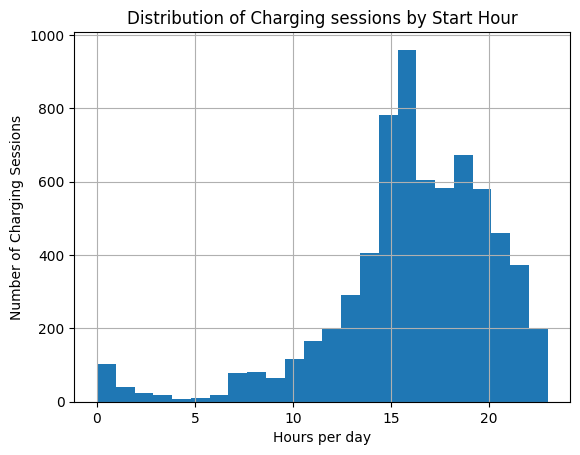

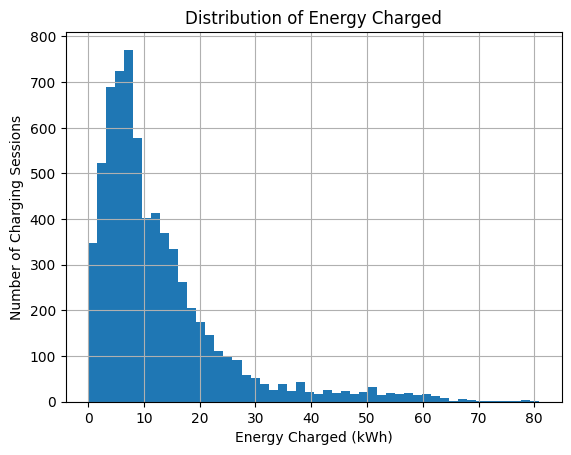

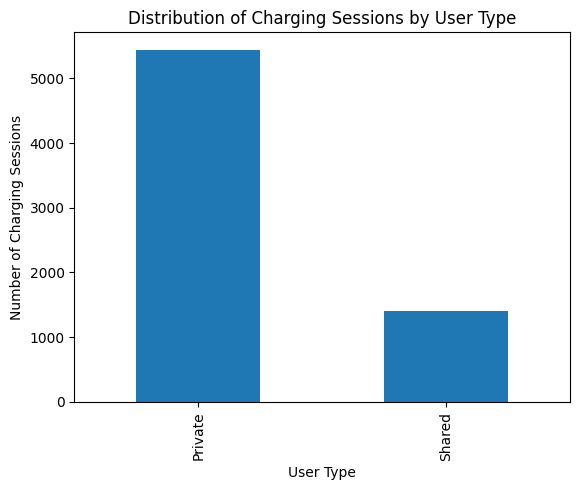

In [ ]:
df['start_plugin_hour'].hist(bins=24)
import matplotlib.pyplot as plt
plt.xlabel('Hours per day')
plt.ylabel('Number of Charging Sessions')
plt.title('Distribution of Charging sessions by Start Hour')
plt.show()
df['el_kwh'].hist(bins=50)
plt.xlabel('Energy Charged (kWh)')
plt.ylabel('Number of Charging Sessions')
plt.title('Distribution of Energy Charged')
plt.show()
df['user_type'].value_counts().plot(kind='bar')
plt.xlabel('User Type')
plt.ylabel('Number of Charging Sessions')
plt.title('Distribution of Charging Sessions by User Type')
plt.show()

# transforming to parquets

In [ ]:
#saving df to parquet into a single file
#local_path = '../data/processed/raw_parquet/trondheim_sessions_v1.parquet'
#df.to_parquet(local_path, index=False, engine='pyarrow', compression='snappy')
#print("Saved to:", local_path)

In [ ]:
# create year/month columns for partitioning
df['year'] = df['start_plugin'].dt.year
df['month'] = df['start_plugin'].dt.month

out_dir = '../data/processed/raw_parquet/partitionned'
# partitioning by year and month (allows us for faster time-based queries later)
df.to_parquet(out_dir, index=False, engine='pyarrow',
              compression='snappy', partition_cols=['year','month'])

print("Partitioned Parquet saved at:", out_dir)

Partitioned Parquet saved at: ../data/processed/raw_parquet/partitionned


# Uploading to localstack s3 buckt

In [ ]:
import boto3
import os

# LocalStack endpoint
LOCALSTACK_ENDPOINT = "http://localhost:4566"
s3 = boto3.client('s3', endpoint_url=LOCALSTACK_ENDPOINT,
                  aws_access_key_id="test", aws_secret_access_key="test")

# create bucket if not exists (LocalStack ignores region)
try:
    s3.create_bucket(Bucket="ev-data")
except Exception as e:
    print("create_bucket:", e)

# if you saved a partitioned folder, upload recursively:
import pathlib
folder = pathlib.Path('../data/processed/raw_parquet/trondheim_sessions_v1_partitioned')
for p in folder.rglob('*.parquet'):
    # compute key relative to folder
    relative = p.relative_to(folder)
    key = f'raw/trondheim_partitioned/{relative.as_posix()}'
    s3.upload_file(str(p), "ev-data", key)
    print("Uploaded:", key)


# Verifying the files existance

In [ ]:
# List all objects recursively in the bucket
response = s3.list_objects_v2(Bucket="ev-data", Prefix="raw/")

# Print each file
for obj in response.get('Contents', []):
    print(f"Key: {obj['Key']}, Size: {obj['Size']} bytes")

# Reading from the s3 bucket

In [ ]:
# donwloading then reading the downloaded file
download_path = '../data/downloaded/trondheim_download.parquet'
s3.download_file("ev-data", "raw/trondheim_partitioned/year=2020/month=1/39b0d0debd45456488561c24e7466d83-0.parquet", download_path)
df2 = pd.read_parquet(download_path, engine='pyarrow')
df2.head()

ClientError: An error occurred (404) when calling the HeadObject operation: Not Found

In [ ]:
# reading directly from s3 bucket
import pandas as pd

s3_path = 's3://ev-data/raw/trondheim_partitioned/year=2019/month=10/39b0d0debd45456488561c24e7466d83-0.parquet'
storage_options = {
    "client_kwargs": {"endpoint_url": "http://localhost:4566"},
    "key": "test", "secret": "test"  
}
df_from_s3 = pd.read_parquet(s3_path, engine='pyarrow', storage_options=storage_options)
df_from_s3.head()

,session_id,garage_id,user_id,user_type,shared_id,start_plugin,start_plugin_hour,end_plugout,end_plugout_hour,el_kwh,duration_hours,month_plugin,weekdays_plugin,plugin_category,duration_category,year,month
0,2543,Bl2,Share-28,Shared,Shared-6,2019-10-01 06:50:00,6,2019-10-01 07:33:00,7.0,4.87,0.721389,Oct,Tuesday,early morning (6-9),Less than 3 hours,2019,10
1,2544,SR2,SR2-2,Private,None,2019-10-01 12:20:00,12,2019-10-01 20:28:00,20.0,7.51,8.130556,Oct,Tuesday,early afternoon (12-15),Between 6 and 9 hours,2019,10
2,2545,Bl2,Bl2-8,Private,None,2019-10-01 12:21:00,12,2019-10-01 15:05:00,15.0,17.18,2.745000,Oct,Tuesday,early afternoon (12-15),Less than 3 hours,2019,10
3,2546,UT15,UT15-1,Private,None,2019-10-01 15:18:00,15,2019-10-01 15:19:00,15.0,0.02,0.010556,Oct,Tuesday,late afternoon (15-18),Less than 3 hours,2019,10
4,2547,UT15,UT15-1,Private,None,2019-10-01 15:20:00,15,2019-10-01 15:21:00,15.0,0.01,0.012778,Oct,Tuesday,late afternoon (15-18),Less than 3 hours,2019,10
